# MACD-V Histogram

https://chartschool.stockcharts.com/table-of-contents/technical-indicators-and-overlays/technical-indicators/macd-v-histogram

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# yahoo finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-01-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)
df.index = pd.Index(df.index.date, name="Date")

# View Columns
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.615894,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.608818,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.797432,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.261932,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.108669,82271200


In [3]:
# Calculate the 12-period EMA
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-period EMA
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

# Calculate the MACD-V
df['MACD_V'] = ((df['EMA_12'] - df['EMA_26']) / df['Close'].rolling(window=26).std()) * 100

# Calculate the Signal Line (9-period EMA of MACD-V)
df['Signal_Line'] = df['MACD_V'].ewm(span=9, adjust=False).mean()

# Calculate the Histogram (MACD-V - Signal Line)
df['Histogram'] = df['MACD_V'] - df['Signal_Line']
    

In [4]:
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,EMA_12,EMA_26,MACD_V,Signal_Line,Histogram
Date,,,,,,,,,,,
2018-02-07,40.772499,40.849998,39.767502,39.884998,37.616734,206434400,41.436177,42.311344,-56.305341,-56.305341,0.000000
2018-02-08,40.072498,40.250000,38.757500,38.787498,36.581646,217562000,41.028688,42.050318,-58.377014,-56.719676,-1.657338
2018-02-09,39.267502,39.472500,37.560001,39.102501,37.029099,282690400,40.732351,41.831961,-58.263106,-57.028362,-1.234744
2018-02-12,39.625000,40.972500,39.377499,40.677502,38.520580,243278000,40.723913,41.746446,-53.313753,-56.285440,2.971687
2018-02-13,40.487499,41.187500,40.412498,41.084999,38.906475,130196800,40.779465,41.697450,-47.843419,-54.597036,6.753617


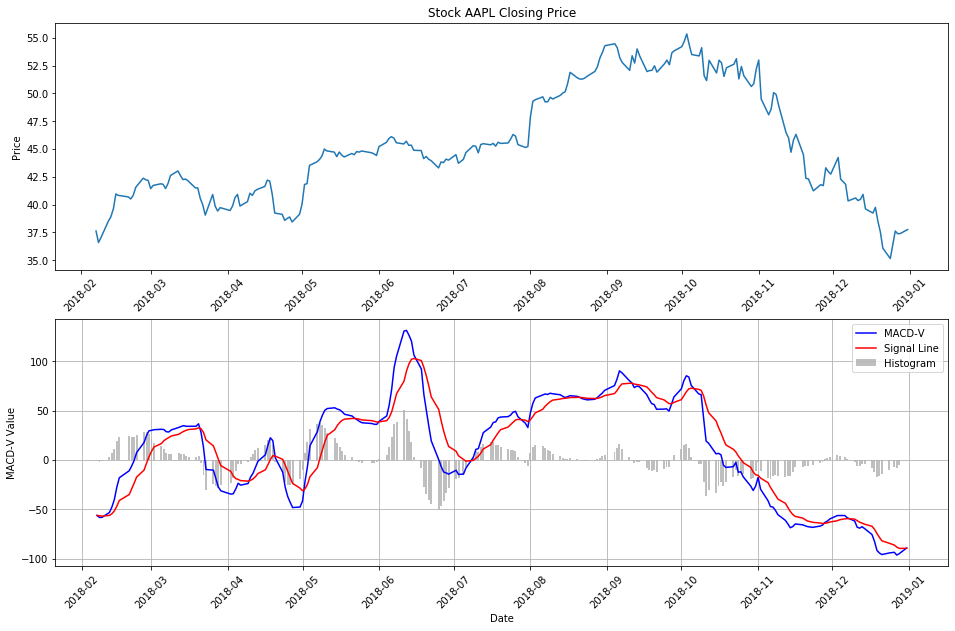

In [5]:
# Create the figure and subplots
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'])
ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.set_ylabel('Price')
ax1.tick_params(axis='x', rotation=45)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['MACD_V'], label='MACD-V', color='blue')
ax2.plot(df['Signal_Line'], label='Signal Line', color='red')
ax2.bar(df.index, df['Histogram'], label='Histogram', color='grey', alpha=0.5)
ax2.grid()
ax2.set_ylabel('MACD-V Value')
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='best')

plt.show()

## Candlestick with MACD-V Histogram

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_12,EMA_26,MACD_V,Signal_Line,Histogram,VolumePositive
0,736732.0,40.772499,40.849998,39.767502,39.884998,37.616734,206434400,41.436177,42.311344,-56.305341,-56.305341,0.000000,False
1,736733.0,40.072498,40.250000,38.757500,38.787498,36.581646,217562000,41.028688,42.050318,-58.377014,-56.719676,-1.657338,False
2,736734.0,39.267502,39.472500,37.560001,39.102501,37.029099,282690400,40.732351,41.831961,-58.263106,-57.028362,-1.234744,False
3,736737.0,39.625000,40.972500,39.377499,40.677502,38.520580,243278000,40.723913,41.746446,-53.313753,-56.285440,2.971687,False
4,736738.0,40.487499,41.187500,40.412498,41.084999,38.906475,130196800,40.779465,41.697450,-47.843419,-54.597036,6.753617,False


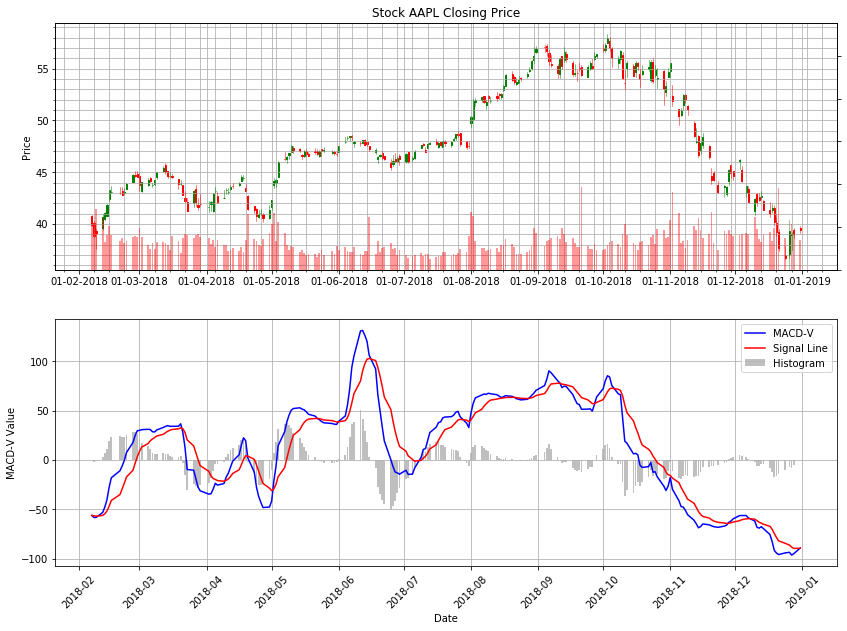

In [7]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['MACD_V'], label='MACD-V', color='blue')
ax2.plot(df['Signal_Line'], label='Signal Line', color='red')
ax2.bar(df.index, df['Histogram'], label='Histogram', color='grey', alpha=0.5)
ax2.grid()
ax2.set_ylabel('MACD-V Value')
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='best')

plt.show()